In [1]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
from PIL import Image
from mmdet.apis import init_detector, inference_detector

path =  "/home/xihelm/catkin_ws/src/tomato_grasp/data/"
img = np.load(path + "rgb_{}.npy".format(18))

/home/xihelm/.local/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


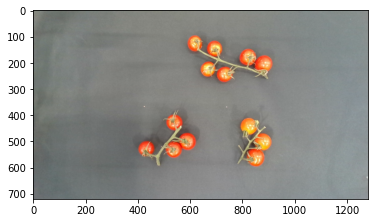

In [2]:
plt.imshow(img)

In [3]:
config_file = '/home/xihelm/mmdetection/configs/mask_rcnn/mask_rcnn_r50_fpn_1x_coco.py'
checkpoint_file = '/home/xihelm/mmdetection/laboro_tomato_little_48ep.pth'
path =  "/home/xihelm/catkin_ws/src/tomato_grasp/data/"
model = init_detector(config_file, checkpoint_file, device='cuda')

load checkpoint from local path: /home/xihelm/mmdetection/laboro_tomato_little_48ep.pth


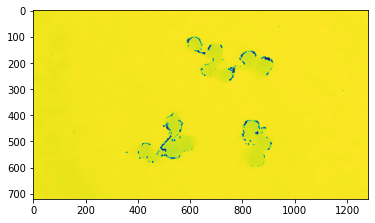

In [193]:
depth = np.load(path + "depth_{}.npy".format(18))
plt.imshow(depth)

In [4]:
img_rgb = img[...,::-1].copy()
result = inference_detector(model, img_rgb)
model.show_result(img_rgb, result, out_file='result.jpg')
im = Image.open('result.jpg')

/home/xihelm/mmdetection/mmdet/datasets/utils.py:66: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


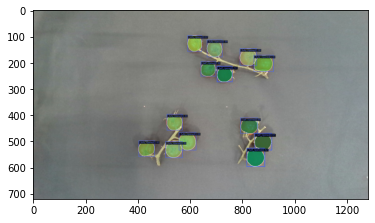

In [5]:
plt.imshow(im)

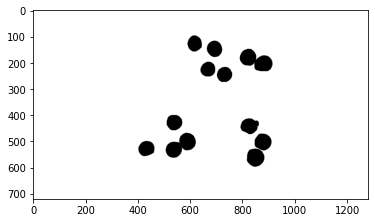

In [6]:
from dataclasses import dataclass
from typing import List

@dataclass
class Tomato:
    xy_centre: List[np.float32]
    bbox: List[int]
    mask: np.ndarray
        
def process_tomato_data(bboxes, masks):

    tomato_data = []
    for bbox, mask in zip(bboxes, masks):

        d_x = bbox[2] - bbox[0]
        d_y = bbox[3] - bbox[1]
        xy_centre = [bbox[0] + d_x * 0.5, bbox[1] + d_y * 0.5]
        tomato_data.append(Tomato(xy_centre, bbox, mask))

    return tomato_data


bboxes = []
masks = []

for bbox_list, mask_list in zip(result[0], result[1]):
    for bbox, mask in zip(bbox_list, mask_list):
        bboxes.append(bbox)
        masks.append(mask)

tomato_data = process_tomato_data(bboxes, masks)

# plot_masks([tom.mask for tom in tomato_data], "segmentation_tomatoes_laboro.png")

# # Combine all the individual tomato masks into a single mask
single_tomatoes_all = np.zeros(img_rgb.shape[:2])
for tomato in tomato_data:
    single_tomatoes_all = np.logical_or(single_tomatoes_all, tomato.mask)

im = Image.fromarray(single_tomatoes_all)
plt.imshow(im)


im = Image.fromarray(np.invert(single_tomatoes_all))
plt.imshow(im)

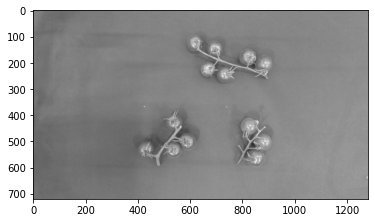

In [7]:
gray = np.mean(img_rgb, axis=2)
gray = Image.fromarray(gray)
plt.imshow(gray)

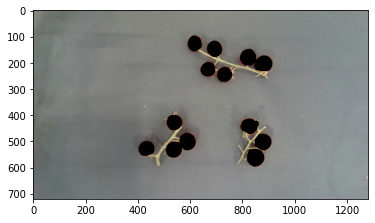

In [130]:
no_tomatoes = np.logical_not(gray, np.invert(single_tomatoes_all))
no_tomatoes = img * np.invert(single_tomatoes_all)[..., None]
plt.imshow(no_tomatoes)

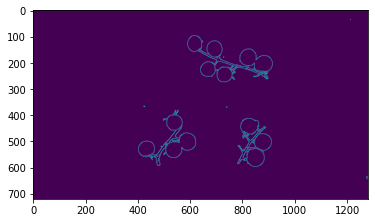

In [131]:
edges = cv.Canny(no_tomatoes,50,200)
plt.imshow(edges)

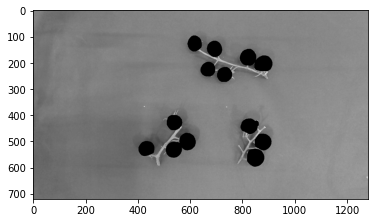

In [132]:
no_tomatoes_gray = np.mean(no_tomatoes, axis=2)
no_tomatoes_gray_img = Image.fromarray(no_tomatoes_gray)
plt.imshow(no_tomatoes_gray_img)

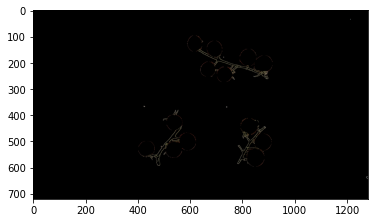

In [183]:
from scipy.ndimage import gaussian_filter
peduncles = np.logical_and(single_tomatoes_all, edges)
peduncles = np.logical_and(np.invert(peduncles), edges)
peduncles.dtype = np.uint8
kernel = np.ones((5, 5), np.uint8)
# result = cv.bitwise_and(cv.erode(img, kernel, iterations=1), 
#                         cv.erode(img, kernel, iterations=1),
#                                  mask = peduncles)
result = cv.bitwise_and(img, img, mask = peduncles)
plt.imshow(result)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


error: OpenCV(4.6.0) :-1: error: (-5:Bad argument) in function 'line'
> Overload resolution failed:
>  - img is not a numerical tuple
>  - Expected Ptr<cv::UMat> for argument 'img'


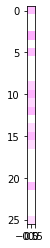

In [144]:
lines = cv.HoughLinesP(peduncles,1,np.pi/180,40,minLineLength=30,maxLineGap=30)
plt.imshow(lines)
i = 0
for x1,y1,x2,y2 in lines[0]:
    i+=1
    cv.line(result,(x1,y1),(x2,y2),(255,0,0),1)
print(i)

cv.imshow("res",result)

In [226]:
length = len(tomato_data)
points = []

for i in range(0, length):
    for j in range(i, length):
        if i == j: 
            continue
        points.append([tomato_data[i].xy_centre, tomato_data[j].xy_centre])
    
x_coords, y_coords = zip(*points)
M = []
C = []
for coords in points:
    x_coords, y_coords = zip(*coords)
    A = np.vstack([x_coords, np.ones(len(x_coords))]).T
    m, c = np.linalg.lstsq(A, y_coords)[0]
    # print("Line Solution is y = {m}x + {c}".format(m=m,c=c))
    mp = (x_coords[0] / 2 + x_coords[1] / 2, y_coords[0] / 2 + y_coords[1] / 2)
    c_bisector = mp[1] - (-1/m)*mp[0]
    print("Bisector solution is y = {m}x + {c}".format(m=-1/m,c=c_bisector))
    M.append(-1/m)
    C.append(c_bisector)

Bisector solution is y = 1.066621217544633x + -41.67860025749337
Bisector solution is y = 1.5187620263771993x + -763.6752818852979
Bisector solution is y = 1.135813878439864x + -470.24907569723894
Bisector solution is y = -0.6698770217325769x + 843.0993264802726
Bisector solution is y = 0.021982791024591018x + 468.29801404148725
Bisector solution is y = 0.5429074432683277x + -47.56113356431115
Bisector solution is y = 0.2544745215759041x + 130.36628736346435
Bisector solution is y = -2.307541061694683x + 2101.28812907989
Bisector solution is y = 1.0429975549427313x + -328.008123632005
Bisector solution is y = -4.47868716383775x + 3645.1256433282138
Bisector solution is y = 0.632577501337568x + -56.2175854397035
Bisector solution is y = -18.114331482272544x + 12813.809616275617
Bisector solution is y = -21.047067128231003x + 14812.953465049006
Bisector solution is y = 0.6339503831888321x + -57.3089726203857
Bisector solution is y = -4.596211579551653x + 3728.847448310058
Bisector soluti

/tmp/ipykernel_1202418/884046333.py:16: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  m, c = np.linalg.lstsq(A, y_coords)[0]


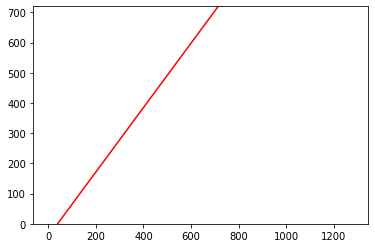

In [227]:
x = np.arange(0, img.shape[1])
y = 1.066621217544633 * x + -41.67860025749337
ax = plt.gca()
ax.set_ylim([0, img.shape[0]])
plt.plot(x, y, '-r', label='y=2x+1')

720
(720, 1280)


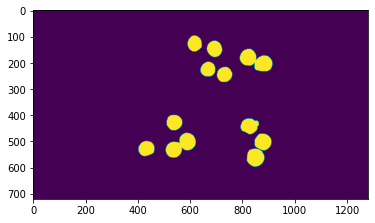

In [228]:
plt.imshow(single_tomatoes_all)
print(len(single_tomatoes_all==True))
print(single_tomatoes_all.shape)

720


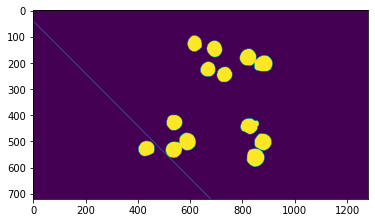

In [229]:
height, width = img.shape[0], img.shape[1]
m_ = []
c_ = []
for m, c in zip(M, C):
    l = np.fromfunction(lambda i, j: j == int(m)*i+int(c), (height, width), dtype=np.float32)
    res = np.logical_or(l, single_tomatoes_all)
    print(len(res==True))
    plt.imshow(res)
    break

In [230]:
from shapely.geometry import LineString, Point, Polygon
for tomato in tomato_data:
    print(tomato.bbox)
    polygon = Polygon( [(tomato.bbox[0], tomato.bbox[1]), 
                       (tomato.bbox[2], tomato.bbox[1]),
                       (tomato.bbox[0], tomato.bbox[3]),
                       (tomato.bbox[2], tomato.bbox[3])]
                     )

[511.052     397.71277   570.90045   458.08682     0.9999542]
[403.18637   498.60214   464.33557   558.2346      0.9998301]
[843.58124   172.67162   918.0738    235.59073     0.9972746]
[790.3506    147.38814   854.43286   212.88045     0.9966708]
[557.32056   466.754     622.3103    534.861       0.9955401]
[506.796     501.1891    570.5607    563.671       0.9934087]
[664.055     114.862625  722.75775   179.40425     0.9858123]
[590.12665    97.05459   644.65894   158.16177     0.9747565]
[816.3061    527.61035   885.9726    597.0149      0.9503196]
[703.0612    214.77295   761.89386   273.8133      0.9290714]
[8.4637177e+02 4.7168921e+02 9.1135114e+02 5.3499622e+02 5.5372906e-01]
[6.4034808e+02 1.9794977e+02 6.9805554e+02 2.5244310e+02 2.6043952e-01]
[7.9261664e+02 4.1408081e+02 8.5874762e+02 4.7315311e+02 1.6988173e-01]
[792.3686     411.9392     858.27795    470.8805       0.99178433]
[641.87634    196.91852    697.3958     252.98227      0.98174816]
[846.74384    469.14072    912

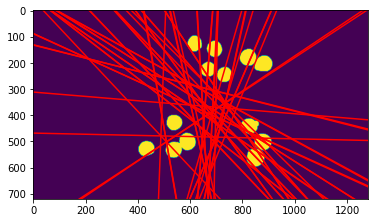

In [233]:
width = img.shape[1]
x = np.linspace(0, width ,10)
n = 0
for m, c in zip(M, C):
    y = (m * x + c)
    plt.plot(x, y, '-r', label='y=2x+1')
    if n == 50:
        break
    n+=1
plt.imshow(single_tomatoes_all)
#plt.imshow(result)
plt.show()